# Problem 5
How efficient are these indices? Let’s estimate both the time and space. Using the RegexPreprocessor, tokenize the first 10,000 documents. Then for each inverted index implementation, use the Indexer to create an index with the first 10, 100, 1000, and 10000 documents in the collection (what was just preprocessed). 

Record (1) how long it took to index that many documents and (2) how much memory the index consumed. Record these sizes and timestamps. Make a plot for each, showing the number of documents on the x-axis and either time or memory on the y-axis. Tips: If sizing the index at each step is taking too long, you can size the index every 1000 steps. Estimate how big the positional index might get in memory for the entire collection and how long it would take with that indexer. In a sentence, describe whether you think you could fit the positional index in memory on your own computer and why.

In [1]:
import time
import json
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pympler import asizeof
import sys
from document_preprocessor import RegexTokenizer
from indexing import Indexer, IndexType
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
dataset_path = 'data/wikipedia_200k_dataset.jsonl.gz'

def load_documents(file_path, num_docs=10000):
    documents = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= num_docs:
                break
            doc = json.loads(line)
            documents.append(doc)
    return documents

documents = load_documents(dataset_path, num_docs=10000)
print(f"Loaded {len(documents)} documents.")

Loaded 10000 documents.


In [3]:
tokenizer = RegexTokenizer(lowercase=True)
doc_counts = [10, 100, 1000, 10000]

In [4]:
results = {
    'BasicInvertedIndex': {'docs': [], 'times': [], 'memories': []},
    'PositionalInvertedIndex': {'docs': [], 'times': [], 'memories': []}
}

stopwords = set()
minimum_word_frequency = 0

def get_size(obj):
    return asizeof.asizeof(obj)

for index_type in [IndexType.BasicInvertedIndex, IndexType.PositionalIndex]:
    print(f"\nIndexing with {index_type.value}")
    for num_docs in doc_counts:
        print(f"\nNumber of documents: {num_docs}")
        start_time = time.time()
        # Create the index
        index = Indexer.create_index(
            index_type=index_type,
            dataset_path=dataset_path,
            document_preprocessor=tokenizer,
            stopwords=stopwords,
            minimum_word_frequency=minimum_word_frequency,
            text_key='text',
            max_docs=num_docs
        )
        end_time = time.time()
        elapsed_time = end_time - start_time
        index_size = get_size(index)
        index_name = index_type.value
        results[index_name]['docs'].append(num_docs)
        results[index_name]['times'].append(elapsed_time)
        results[index_name]['memories'].append(index_size)
        print(f"Indexing time: {elapsed_time:.2f} seconds")
        print(f"Index size: {index_size / (1024 * 1024):.2f} MB")

Building index:  30%|███       | 3/10 [00:00<00:00, 28.55it/s]


Indexing with BasicInvertedIndex

Number of documents: 10


Building index:   3%|▎         | 3/100 [00:00<00:04, 23.65it/s]

Indexing time: 0.33 seconds
Index size: 7.75 MB

Number of documents: 100


Building index:   0%|          | 3/1000 [00:00<00:41, 23.83it/s]

Indexing time: 2.72 seconds
Index size: 49.99 MB

Number of documents: 1000


Building index:   0%|          | 4/10000 [00:00<04:30, 36.99it/s]

Indexing time: 13.60 seconds
Index size: 245.61 MB

Number of documents: 10000


Building index:  20%|██        | 2/10 [00:00<00:00, 18.59it/s]

Indexing time: 57.02 seconds
Index size: 1097.40 MB

Indexing with PositionalInvertedIndex

Number of documents: 10


Building index:   2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

Indexing time: 1.95 seconds
Index size: 19.60 MB

Number of documents: 100


Building index:   0%|          | 2/1000 [00:00<00:55, 17.99it/s]

Indexing time: 4.85 seconds
Index size: 132.03 MB

Number of documents: 1000


Building index:   0%|          | 2/10000 [00:00<12:54, 12.92it/s]

Indexing time: 24.93 seconds
Index size: 630.17 MB

Number of documents: 10000


Building index: 100%|██████████| 10000/10000 [02:13<00:00, 74.90it/s] 


Indexing time: 134.50 seconds
Index size: 2657.74 MB


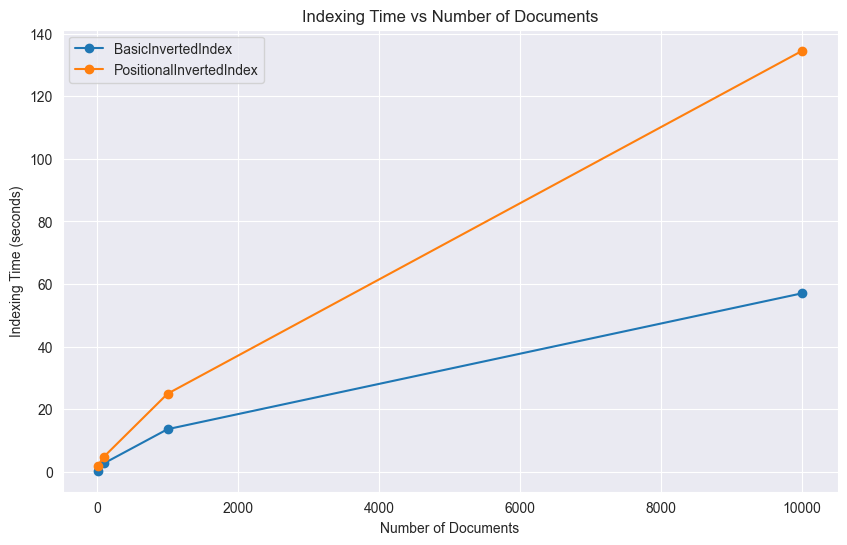

In [5]:
plt.figure(figsize=(10, 6))
for index_name in results:
    plt.plot(results[index_name]['docs'], results[index_name]['times'], marker='o', label=index_name)
plt.xlabel('Number of Documents')
plt.ylabel('Indexing Time (seconds)')
plt.title('Indexing Time vs Number of Documents')
plt.legend()
plt.grid(True)
plt.show()

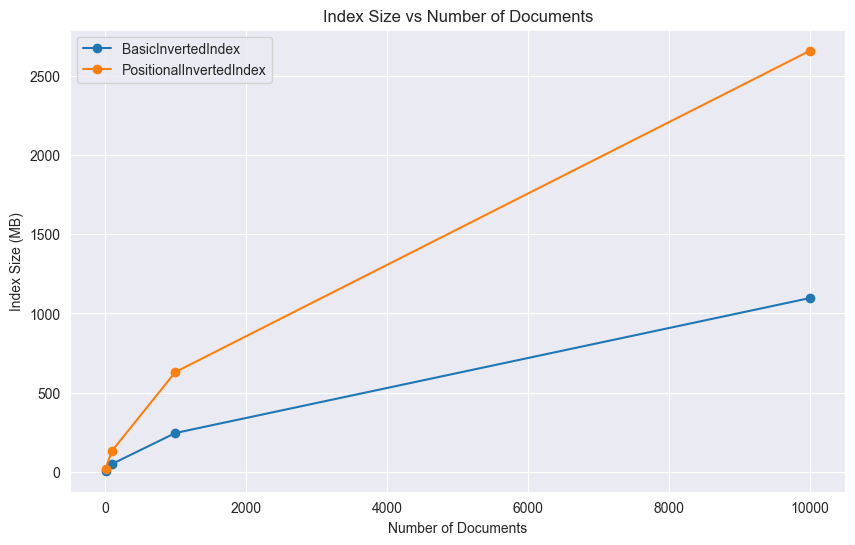

In [6]:
plt.figure(figsize=(10, 6))
for index_name in results:
    sizes_mb = [size / (1024 * 1024) for size in results[index_name]['memories']]
    plt.plot(results[index_name]['docs'], sizes_mb, marker='o', label=index_name)
plt.xlabel('Number of Documents')
plt.ylabel('Index Size (MB)')
plt.title('Index Size vs Number of Documents')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
total_docs = 200000

def estimate_total(index_name, total_docs):
    X = np.array(results[index_name]['docs']).reshape(-1, 1)
    y_time = np.array(results[index_name]['times'])
    time_model = LinearRegression()
    time_model.fit(X, y_time)
    estimated_time = time_model.predict([[total_docs]])[0]
    y_size = np.array(results[index_name]['memories'])
    size_model = LinearRegression()
    size_model.fit(X, y_size)
    estimated_size = size_model.predict([[total_docs]])[0]
    return estimated_time, estimated_size

estimated_time, estimated_size = estimate_total('PositionalInvertedIndex', total_docs)

print(f"Estimated indexing time for {total_docs} documents: {estimated_time / 3600:.2f} hours")
print(f"Estimated index size: {estimated_size / (1024 * 1024 * 1024):.2f} GB")

Estimated indexing time for 200000 documents: 0.72 hours
Estimated index size: 49.35 GB


# Conclusion:

Based on the estimated size of the positional index for the entire collection of 200,000 documents, which is approximately 49.35 GB, and considering that my computer has 32 GB of RAM, I conclude that it is NOT feasible to fit the positional index in memory on my own computer. The index would exceed the available memory, leading to potential memory errors or system slowdowns.